# Neural Network for Cat Classification

In [50]:
# Install necessary libraries (run in a terminal if needed)
!pip install --upgrade pip
!pip install tensorflow==2.18.0
!pip install scikit-learn
!pip install imbalanced-learn
!pip install pandas numpy matplotlib jupyter openpyxl seaborn


In [51]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt


## Step 1: Data Preprocessing

In [52]:
# Load the dataset
data = pd.read_excel('Dataset (2).xlsx', sheet_name='Data')

# Define preprocessing function
def preprocess_data(data):
    df = data.copy()
    df.replace('Unknown', pd.NA, inplace=True)
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
    if 'NaturalAreasAbundance' in df.columns:
        df['NaturalAreasAbundance'] = df['NaturalAreasAbundance'].fillna(-1)
    categorical_cols = ['Age', 'HousingType', 'Zone']
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            label_encoders[col] = LabelEncoder()
            df[col] = df[col].fillna('Unknown')
            df[col] = label_encoders[col].fit_transform(df[col].astype(str))
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='mean')
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    if 'Race' in df.columns:
        label_encoder_race = LabelEncoder()
        df['Race'] = df['Race'].fillna('Unknown')
        df['Race'] = label_encoder_race.fit_transform(df['Race'].astype(str))
    return df, label_encoders

# Preprocess the dataset
processed_data, label_encoders = preprocess_data(data)
X = processed_data.drop(columns=['Race'])
y = processed_data['Race']

# Split and balance the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Scale the balanced dataset
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test)


## Step 2: Model definition

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define a new architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')  # Number of classes
])

# Compile with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))




# Step 4: Training

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
history = model.fit(
    X_balanced, y_balanced,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0774 - loss: 3.0865 - val_accuracy: 0.0310 - val_loss: 2.9698 - learning_rate: 1.0000e-04
Epoch 2/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1290 - loss: 2.7558 - val_accuracy: 0.0171 - val_loss: 3.2733 - learning_rate: 1.0000e-04
Epoch 3/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1610 - loss: 2.5906 - val_accuracy: 0.0159 - val_loss: 3.4818 - learning_rate: 1.0000e-04
Epoch 4/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2048 - loss: 2.4599 - val_accuracy: 0.0188 - val_loss: 3.6756 - learning_rate: 1.0000e-04
Epoch 5/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2172 - loss: 2.3924 - val_accuracy: 0.0212 - val_loss: 3.8716 - learning_rate: 1.0000e-04
Epoch 6/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2459 - loss: 2.3161 - val_accuracy: 0.0237 - val_loss: 4.0287 - learning_rate: 1.0000e-04
Epoch 7/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc

# Step 5: Evaluation

Test Accuracy: 0.1017
Test Loss: 2.8103


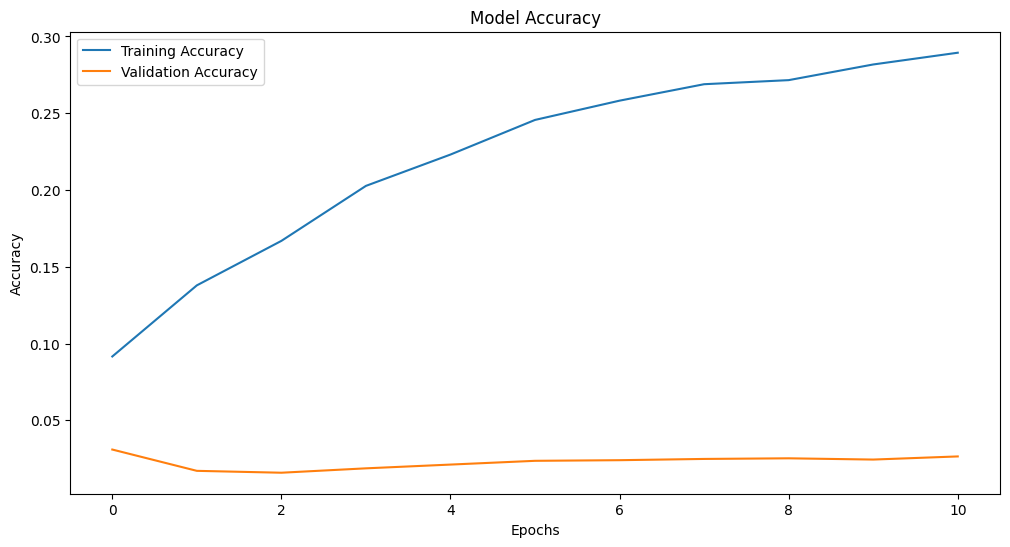

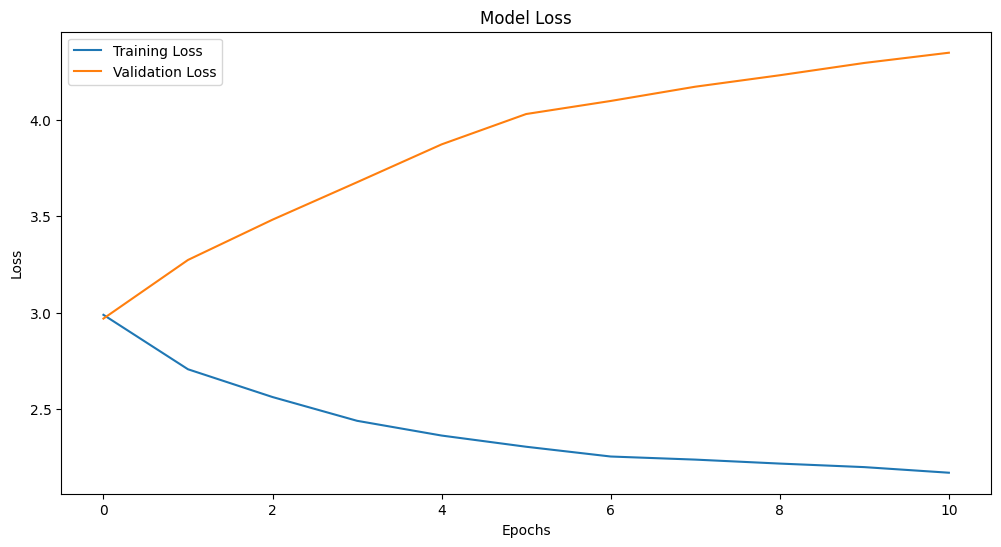

In [60]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
